MARKDOWN CELL:
# 🚪🚪🚪 The Monty Hall Problem: Frequentist Simulation vs. Bayesian Analysis

This notebook tackles the classic **Monty Hall Problem** to demonstrate two fundamental, yet complementary, approaches to probability and inference:

* **Frequentist (Monte Carlo Simulation)**: Estimating probabilities through the long-run relative frequency of outcomes in repeated, independent trials (simulations).
* **Bayesian (Bayes' Theorem)**: Updating our initial belief (**prior**) about an outcome based on new evidence (**likelihood**) to form a refined belief (**posterior**).

## 📌 Classical Monty Hall Setup

1.  **Three Doors**: One car (the prize) and two goats are placed randomly behind doors 1, 2, and 3
2.  **Player's Initial Choice**: The player picks one door, $\mathbf{D}_{\text{pick}}$, uniformly at random (could have chosen any one)
3.  **Host's Action**: The host (who knows where the car is) opens one of the *other* two doors, $D_{open}$, revealing a goat
4.  **The Offer**: The host always offers the player the choice to **stay** with their initial pick or **switch** to the other remaining closed door, $D_{switch}$
5.  **Host's Rules (Crucial)**:
    * The host must always open one of the doors the player did not pick
    * The host must always open a door with a goat (not the one with the car)
    * If the host has two goat doors to choose from (i.e. the player's initial pick was the car), the host chooses which goat door to open uniformly at random (50/50)

## 💡 Learning Goals: Frequentist vs. Bayesian

By the end of this exercise, you will be able to:

* **Frequentist Insight**: Simulate a process many times to empirically estimate the true underlying probability, demonstrating how **relative frequencies** converge to the **theoretical probability** (Law of Large Numbers)
* **Bayesian Insight**: Apply **Bayes' theorem** to formally update an initial **prior belief** ($P(Car)$) using the new evidence provided by the host's action ($P(Host\text{ opens } Goat)$) to calculate the refined **posterior probability** ($P(Car \mid Host\text{ opens } Goat)$)
* **Conceptual Clarity**: Explain *why* switching doors is the optimal strategy and demonstrate how both paradigms arrive at the same conclusion: **2/3 probability of winning by switching**

## Setup

Run the following cell to import libraries and set a reproducible random seed


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(42)  # reproducibility

## Part 1: 📊 Frequentist Simulation (Monte Carlo)

The **Frequentist** approach estimates the probability of an event by running the experiment repeatedly and calculating the **relative frequency** of that event. The Law of Large Numbers dictates that as the number of trials ($N$) grows, the empirical relative frequency converges to the true theoretical probability.

We expect:
* **Stay Probability**: $1/3$ (since the initial choice is random among three doors).
* **Switch Probability**: $2/3$ (since the probability that the car was *not* behind your initial pick is $2/3$, and the host's action transfers that $2/3$ probability to the remaining door).

In [ ]:
# ---------------------------------------------------------------
# Function to simulate the Monty Hall problem
# ---------------------------------------------------------------
def simulate_monty_hall(n_trials: int, track_running: bool = False, seed: int | None = None) -> dict:
    """
    Simulates the classic Monty Hall game n_trials times.
    Optionally tracks the running (cumulative) win rate to show convergence.

    Parameters
    ----------
    n_trials : int
        How many times to repeat the Monty Hall experiment
    track_running : bool
        If True, store and return running averages to show convergence over time
    seed : int | None
        Random seed for reproducibility

    Returns
    -------
    dict
        Dictionary with total wins for staying and switching,
        and optional arrays of running win rates.
    """

    # Create a random number generator for reproducibility (better than np.random.seed)
    rng = np.random.default_rng(seed)

    # Randomly assign the car behind one of 3 doors (0, 1, or 2) for each trial
    car_doors = rng.integers(0, 3, size=n_trials)

    # Randomly pick the player’s initial door (uniform probability)
    picks = rng.integers(0, 3, size=n_trials)

    # Prepare an empty array to store which door the host opens each time
    host_opens = np.empty(n_trials, dtype=int)

    # Initialize counters for how many times staying or switching wins
    stay_wins = 0
    switch_wins = 0

    # If we want to track convergence, prepare arrays for running averages
    if track_running:
        running_stay = np.empty(n_trials, dtype=float)
        running_switch = np.empty(n_trials, dtype=float)

    # ---------------------------------------------------------------
    # Main simulation loop: run the game n_trials times
    # ---------------------------------------------------------------
    for i in range(n_trials):
        # 1. The host can open any door except the one the player picked
        available = {0, 1, 2} - {picks[i]}

        # 2. But if the car isn’t behind the chosen door,
        #    the host must avoid the door hiding the car
        if car_doors[i] != picks[i]:
            available = available - {car_doors[i]}

        # 3. From the remaining doors, the host opens one at random
        host_opens[i] = rng.choice(list(available))

        # 4. Only one unopened door remains after the host opens a goat door
        remaining = 3 - picks[i] - host_opens[i]
        # This arithmetic works because 0 + 1 + 2 = 3 (door indices),
        # so the remaining door is the one not chosen or opened.

        # 5. Check outcomes for both strategies
        stay_wins += int(picks[i] == car_doors[i])      # Did staying win?
        switch_wins += int(remaining == car_doors[i])    # Did switching win?

        # 6. If tracking, update running averages after each trial
        if track_running:
            running_stay[i] = stay_wins / (i + 1)
            running_switch[i] = switch_wins / (i + 1)

    # Store results in a dictionary to make it easy to return multiple outputs
    out = {
        "stay_wins": int(stay_wins),
        "switch_wins": int(switch_wins),
        "n_trials": int(n_trials)
    }

    # Add the running arrays if requested (for the convergence plot)
    if track_running:
        out["running_stay"] = running_stay
        out["running_switch"] = running_switch

    return out

### 📊 Bar Chart Comparison: Empirical vs. Theoretical

To visualize the concept of convergence and the influence of sample size, we use a bar chart to directly compare the **Empirical Win Rate** (what happened in the simulation) against the **Theoretical Win Rate** (what the math predicts).

By generating plots with increasing trial counts ($\mathbf{N}$), we clearly demonstrate how **small samples yield high variability and unreliable results**, while large samples closely match the theoretical prediction.

Generating bar charts to show convergence...


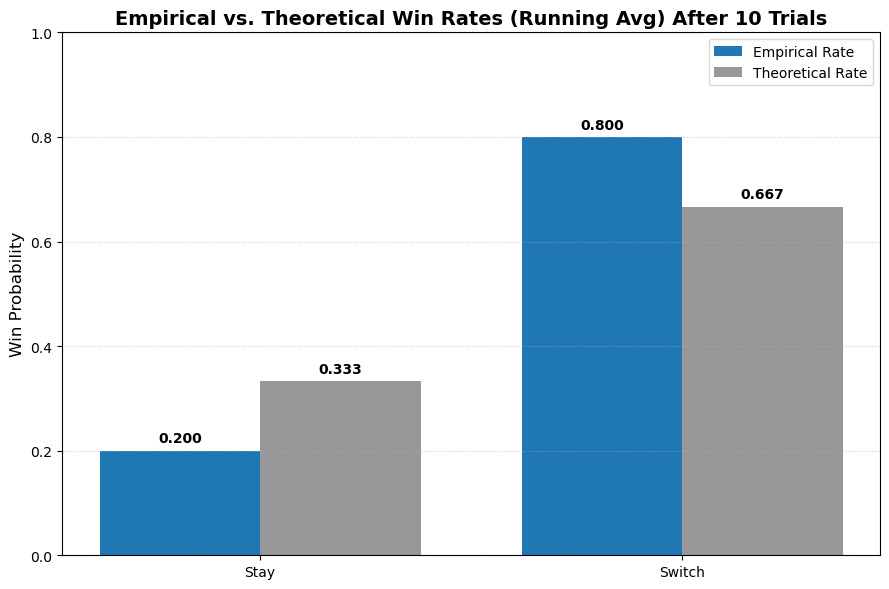

In [35]:
# ---------------------------------------------------------------
# Function to plot Empirical vs. Theoretical Probabilities
# ---------------------------------------------------------------
def plot_empirical_vs_theoretical(n_trials: int, seed: int | None = None) -> None:
    """
    Plot empirical win rates from a simulation next to the theoretical rates
    for the Stay vs. Switch strategies using a grouped bar chart.

    Parameters
    ----------
    n_trials : int
        The number of games simulated to obtain the empirical rates.
    seed : int | None
        Random seed for simulation reproducibility.
    """
    
    # Run the simulator once for a batch of N games, passing the seed for reproducibility
    res = simulate_monty_hall(n_trials, track_running=False, seed=seed) 

    # --- 1. Calculate Rates ---
    # Convert simulation counts to empirical probabilities (Frequentist approach)
    stay_empirical_rate = res["stay_wins"] / n_trials
    switch_empirical_rate = res["switch_wins"] / n_trials

    # Theoretical probabilities for the classical Monty Hall setup
    stay_theoretical_rate = 1/3
    switch_theoretical_rate = 2/3

    # --- 2. Prepare Data for Grouped Bars ---
    strategies = ["Stay", "Switch"]
    empirical_rates = np.array([stay_empirical_rate, switch_empirical_rate])
    theoretical_rates = np.array([stay_theoretical_rate, switch_theoretical_rate])

    # Set bar positions and width so Empirical and Theoretical appear side by side
    x = np.arange(len(strategies))       # Positions for the two strategy groups (0 and 1)
    width = 0.38                         # Width of each bar for side-by-side comparison

    # --- 3. Create Plot ---
    plt.figure(figsize=(9, 6))

    # Draw bars for empirical rates (left bar in each group)
    bar1 = plt.bar(
        x - width/2, 
        empirical_rates, 
        width, 
        label="Empirical Rate",
        color='tab:blue' # Use a solid color for empirical data
    )
    
    # Draw bars for theoretical rates (right bar in each group)
    bar2 = plt.bar(
        x + width/2, 
        theoretical_rates, 
        width, 
        label="Theoretical Rate",
        color='tab:gray', # Use a neutral color for reference data
        alpha=0.8
    )

    # --- 4. Add Value Labels for Clarity ---
    def add_labels(bars):
        """Helper function to add value labels on top of the bars."""
        for bar in bars:
            yval = bar.get_height()
            # Format the label to 3 decimal places
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, 
                     f"{yval:.3f}", ha="center", va="bottom", fontweight="bold")

    add_labels(bar1)
    add_labels(bar2)

    # --- 5. Cosmetic Settings ---
    plt.xticks(x, strategies)
    plt.ylim(0, 1.0)
    plt.ylabel("Win Probability", fontsize=12)
    plt.title(f"Empirical vs. Theoretical Win Rates (Running Avg) After {n_trials} Trials", 
              fontsize=14, fontweight="bold")
    plt.grid(axis="y", linestyle=":", alpha=0.6)
    plt.legend(loc='upper right')
    plt.tight_layout()  
    plt.show()

# ---------------------------------------------------------------
# Example Execution: Illustrate convergence by increasing trials
# ---------------------------------------------------------------

# Try several N to illustrate variability at small samples vs stability at large samples
print("Generating bar charts to show convergence...")
for N in [
    10, 
    # 100, 
    # 1000, 
    # 100000,
]:
    plot_empirical_vs_theoretical(N, seed=42)

### 📉 Full Convergence Plot

This plot shows the running average probability over the entire simulation ($\mathbf{N=200,000}$). This is the essential Frequentist view.

Observe how the lines initially jump with high variance (due to chance) but quickly stabilize and converge precisely on the dashed theoretical lines, demonstrating that **switching doors provides a consistent, long-term $\mathbf{2/3}$ advantage**.

Total trials: 200000
Final stay win rate:   0.3353  (Expected 1/3 ≈ 0.3333)
Final switch win rate: 0.6647  (Expected 2/3 ≈ 0.6667)


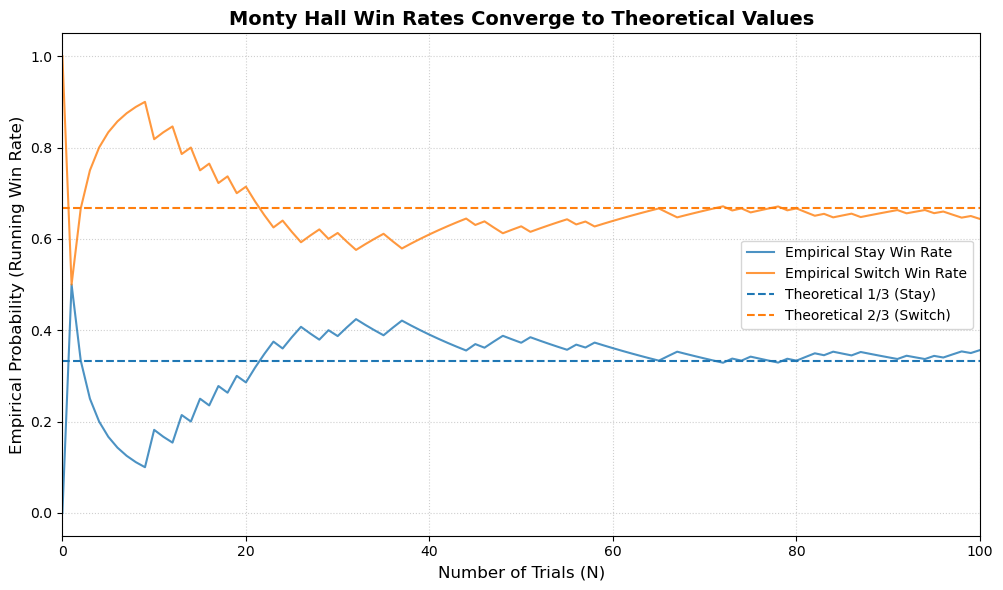

In [ ]:
# ---------------------------------------------------------------
# Run the simulation and visualize convergence (Frequentist View)
# ---------------------------------------------------------------

# Number of games to simulate
N = 200000   # A large number makes the convergence smooth (Law of Large Numbers)

# Run the simulation and ask to track running averages
# We use a fixed seed (42) for reproducible results
res = simulate_monty_hall(N, track_running=True, seed=42)

# Print final win rates to compare with theoretical probabilities
print(f"Total trials: {N}")
print(f"Final stay win rate:   {res['running_stay'][-1]:.4f}  (Expected 1/3 ≈ 0.3333)")
print(f"Final switch win rate: {res['running_switch'][-1]:.4f}  (Expected 2/3 ≈ 0.6667)")


# ---------------------------------------------------------------
# Plot the convergence of probabilities
# ---------------------------------------------------------------

plt.figure(figsize=(10, 6))

# Plot running averages over trials
plt.plot(res["running_stay"], label="Empirical Stay Win Rate", color='tab:blue', alpha=0.8)
plt.plot(res["running_switch"], label="Empirical Switch Win Rate", color='tab:orange', alpha=0.8)

# Add horizontal dashed lines for theoretical values (the true probabilities)
plt.axhline(1/3, linestyle="--", color="tab:blue", label="Theoretical 1/3 (Stay)")
plt.axhline(2/3, linestyle="--", color="tab:orange", label="Theoretical 2/3 (Switch)")

# Label the axes
plt.xlabel("Number of Trials (N)", fontsize=12)
plt.ylabel("Empirical Probability (Running Win Rate)", fontsize=12)

# Add a descriptive title
plt.title("Monty Hall Win Rates (Running avg) Converge to Theoretical Values", fontsize=14, fontweight='bold')

# Display legend and format nicely
plt.legend(loc='center right')
plt.grid(True, linestyle=':', alpha=0.6, axis='both')
plt.tight_layout()
plt.xlim(0, 100)
plt.show()

In [22]:
# Evaluate across increasing batch sizes to show approximation quality
batch_sizes = [100, 1000, 10000, 100000, 200000]
summary = []
for n in batch_sizes:
    r = simulate_monty_hall(n)
    summary.append((n, r['stay_wins'] / n, r['switch_wins'] / n))
import pandas as pd
df = pd.DataFrame(summary, columns=['trials', 'stay_rate', 'switch_rate'])
df


,trials,stay_rate,switch_rate
0,100,0.38000,0.62000
1,1000,0.31200,0.68800
2,10000,0.33020,0.66980
3,100000,0.33674,0.66326
4,200000,0.33354,0.66646


MARKDOWN CELL:
## Part 2: 🧠 Bayesian Analysis (Updating Beliefs)

The **Bayesian** approach treats probability as a **degree of belief** and uses **Bayes' theorem** to rationally update this belief when **new evidence** is presented.

---

### 📝 Key Definitions

Let:

- **C**: Random variable for the door with the **Car** ($C \in \{1, 2, 3\}$)  <- hypothesis of interest: the actual location of the car
- **D**: The door you initially $\mathbf{D}_{\text{pick}}$ (fixed, e.g., $D = 1$) <- it's fixed and known
- **H**: The event that the **Host** opens a specific goat door $D_{open}$ <- the new evidence, e.g. $H = \text{Host opens Door 3}$ with a goat

We want to find the **Posterior Probability** (our updated belief) of the car's location given the evidence $H$ and our initial pick $D$:

$$
P(C = c \mid H, D) = \frac{P(H \mid C = c, D)\, P(C = c)}{\sum_{c'} P(H \mid C = c', D)\, P(C = c')}
$$

The denominator $P(H \mid D)$ is the **Evidence** (or **Marginal Likelihood**) and acts as a **normalizing constant** (to ensure probabilities sum to 1):

$$
P(H \mid D) = \sum_{c' \in \{1, 2, 3\}} P(H \mid C = c', D)\, P(C = c')
$$

---

### 🚪 Applying Bayes' Theorem: The Example

Let's fix the scenario (without loss of generality, due to symmetry):

1. **Initial Pick**: You choose **Door 1** ($D = 1$) 
2. **Host's Action**: The host opens **Door 3** ($H = \text{Host opens Door 3}$), revealing a goat.

---

#### 1. Prior Probability, $P(C = c)$

Initially, the car is equally likely to be behind any door (a **uniform prior**):

$$
P(C = 1) = P(C = 2) = P(C = 3) = \frac{1}{3}
$$

---

#### 2. Likelihood, $P(H \mid C = c, D = 1)$

This is the probability that the host opens Door 3, *given* the car's actual location $C$. This step is critical, as it incorporates the host's constraints.

| Car Location ($C$) | $P(H = \text{open 3} \mid C, D = 1)$ | Host’s Action Rationale | Contribution to Posterior $\propto P(H \mid C) P(C)$ |
|:---:|:---:|:---|:---:|
| **$C = 1$** (You were right) | $\frac{1}{2}$ | Host must open Door 2 or 3 (both have goats). Chooses randomly (50/50). | $(\frac{1}{2})(\frac{1}{3}) = \frac{1}{6}$ |
| **$C = 2$** (Switch wins) | $1$ | Host is **forced** to open Door 3 (as Door 2 has the car, and Door 1 was picked). | $(1)(\frac{1}{3}) = \frac{1}{3}$ |
| **$C = 3$** (Impossible) | $0$ | Host cannot open Door 3 (it has the car). | $(0)(\frac{1}{3}) = 0$ |

---

#### 3. Posterior Probability, $P(C = c \mid H, D = 1)$

**Total Evidence** (Normalizing Constant):

$$
P(H \mid D) = \frac{1}{6} + \frac{1}{3} + 0 = \frac{3}{6} = \frac{1}{2}
$$

**Posterior probabilities** (After normalization):

$$
P(C = 1 \mid H) = \frac{(1/6)}{(1/2)} = \frac{1}{3}
$$

$$
P(C = 2 \mid H) = \frac{(1/3)}{(1/2)} = \frac{2}{3}
$$

---

> **Conclusion:** After the evidence (the host opening a goat door), the probability that the car is behind your original door ($\mathbf{D = 1}$) remains $\mathbf{1/3}$. The probability that the car is behind the other closed door ($C = 2$) increases to $\mathbf{2/3}$. **Switching doubles your chance of winning.**

MARKDOWN CELL:
## Part 2: 🧠 Bayesian Analysis (Updating Beliefs)

The **Bayesian** approach treats probability as a **degree of belief** and uses **Bayes' theorem** to rationally update this belief when **new evidence** is presented.

---

### 📝 Key Definitions

Let:

- **C**: Random variable for the door with the **Car** ($C \in \{1, 2, 3\}$). This is the **Hypothesis** of interest: the actual location of the car (of which are 3 - one per door)
- **c**: A **Specific Door Number** (e.g. $c=1$ or $c=3$). This is a placeholder for a single outcome of the random variable $C$
- **$D$**: The door you initially **Pick** ($\mathbf{D}_{\text{pick}}$) (fixed, e.g. $D = 1$). This is fixed and known
- **$H$**: The event that the **Host** opens a specific goat door ($\mathbf{D}_{\text{open}}$) (e.g. $H = \text{Host opens Door 3}$). This is the new evidence

We want to find the **Posterior Probability** (our updated belief) of the car's location given the evidence $H$ and the initial pick $D$:

### 🔬 Bayes' Theorem (Concise Form)

This version of the formula shows that the **Posterior Probability** (the refined belief) is calculated from the **Prior** (initial belief) multiplied by the **Likelihood** (new evidence fit), all divided by the **Evidence** (the normalizing constant).

$$
\underbrace{P(C \mid H, D)}_{\text{Posterior}} = \frac{\overbrace{P(H \mid C, D)}^{\text{Likelihood}} \times \overbrace{P(C)}^{\text{Prior}}}{\underbrace{P(H \mid D)}_{\text{Evidence}}}
$$

### ⚙️ Calculating the Posterior: Semi-Full Form

$$
P(C = c \mid H, D) = \frac{P(H \mid C = c, D)\, P(C = c)}{P(H \mid D)}
$$

| Formula Part | Name | What It Asks | Role in the Update |
| :---: | :--- | :--- | :--- |
| $P(H \mid C = c, D)$ | **Likelihood** | What's the probability the host would open door $H$, *if* the car were actually at door $c$? | Measures how well each hypothesis ($C=c$) explains the evidence ($H$). This is the crucial information gained from the host's rules. |
| $P(C = c)$ | **Prior** | What's the probability the car is at door $c$ *before* the host opens anything? | Your initial belief ($\mathbf{1/3}$). |
| **$P(H \mid D)$** | **Evidence** | What is the total probability of seeing the host open door $H$, considering all possibilities for the car's location? | The **Normalizing Constant**. It ensures all posterior probabilities sum to 1. |
| $P(C = c \mid H, D)$ | **Posterior** | What's the probability the car is at door $c$ *after* seeing the host's action $H$? | The **final, updated belief**. This tells you whether to stay or switch. |

"The Probability of the Evidence $H$ given my Pick $D$ ($P(H \mid D)$) is equal to the SUM ($\sum$) of the likelihood and prior product for ALL possible car locations ($c'$ in the set $\{1, 2, 3\}$)."

$$
P(H \mid D) = \sum_{c' \in \{1, 2, 3\}} P(H \mid C = c', D)\, P(C = c')
$$

---

### 🚪 Applying Bayes' Theorem: The Example

Let's fix the scenario:

1. **Initial Pick**: You choose **Door 1** ($D = 1$) 
2. **Host's Action**: The host opens **Door 3** ($H = \text{Host opens Door 3}$), revealing a goat.

---

#### 1. Prior Probability, $P(C = c)$

Initially, the car is equally likely to be behind any door (a **uniform prior**):

$$
P(C = 1) = P(C = 2) = P(C = 3) = \frac{1}{3}
$$

---

#### 2. Likelihood, $P(H = \text{open 3} \mid C = c, D = 1)$

This is the probability that the host opens Door 3, *given* the car's actual location $C$. This step is critical, as it incorporates the host's constraints.

| Car Location ($C$) | $P(H = \text{open 3} \mid C, D = 1)$ | Host’s Action Rationale | Contribution to Posterior $\propto P(H \mid C, D) P(C)$ |
|:---:|:---:|:---|:---:|
| **$C = 1$** (You were right) | $\frac{1}{2}$ | Host must open Door 2 or 3 (both have goats). Chooses randomly (50/50). | $(\frac{1}{2})(\frac{1}{3}) = \frac{1}{6}$ |
| **$C = 2$** (Switch wins) | $1$ | Host is **forced** to open Door 3 (as Door 2 has the car, and Door 1 was picked). | $(1)(\frac{1}{3}) = \frac{1}{3}$ |
| **$C = 3$** (Impossible) | $0$ | Host cannot open Door 3 (it has the car). | $(0)(\frac{1}{3}) = 0$ |

---

#### 3. Posterior Probability, $P(C = c \mid H, D = 1)$

**Total Evidence** (Normalizing Constant):

$$
P(H \mid D) = \frac{1}{6} + \frac{1}{3} + 0 = \frac{3}{6} = \frac{1}{2}
$$

**Posterior probabilities** (After normalization):

$$
P(C = 1 \mid H) = \frac{(1/6)}{(1/2)} = \frac{1}{3}
$$

$$
P(C = 2 \mid H) = \frac{(1/3)}{(1/2)} = \frac{2}{3}
$$

---

### **Conclusion:** 
> ### After the evidence (the host opening a goat door), the probability that the car is behind your original door ($\mathbf{D = 1}$) remains $\mathbf{1/3}$. The probability that the car is behind the other closed door ($C = 2$) increases to $\mathbf{2/3}$. Switching doubles your chance of winning!!🚗🥳

In [ ]:
# CODE CELL

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as w
from IPython.display import display, clear_output

# ---------- Core math ----------
def likelihood_vector_classic(D_idx: int, H_idx: int) -> np.ndarray:
    """L[c] = P(H | C=c, D) for the classic host who never opens D, never reveals car, randomizes if two goats remain"""
    if H_idx == D_idx:
        raise ValueError("Host cannot open the player's chosen door")
    doors = {0, 1, 2}
    L = np.zeros(3, dtype=float)
    for c in range(3):
        if c == D_idx:
            # HYPOTHESIS: Car is at the Picked Door (C=D). Host must randomize (0.5 chance of opening H).
            L[c] = 0.5
        else:
            # HYPOTHESIS: Car is NOT at the Picked Door (C!=D). Host is forced to open one specific door.
            forced = list(doors - {D_idx, c})[0]
            L[c] = 1.0 if H_idx == forced else 0.0
    return L

def bayes_posterior(prior: np.ndarray, like: np.ndarray):
    """
    Applies Bayes' theorem to find the Posterior probability.
    Returns: unnormalized contribution, posterior, and evidence (Z).
    """
    un = prior * like
    Z = float(un.sum())
    if Z == 0:
        raise ValueError("Zero evidence under supplied prior and likelihood")
    return un, un / Z, Z

# ---------- Visualization Helpers ----------
def door_schematic(ax, D_idx: int, H_idx: int):
    """
    Draws the door scenario schematic.
    Blue = picked door, Red = host opens, Orange = remaining closed.
    """
    ax.set_xlim(0, 3)
    ax.set_ylim(0, 1)
    ax.axis("off")
    other_closed = list({0,1,2} - {D_idx, H_idx})[0]
    
    # Define colors based on the role in the scenario:
    colors = ["white"] * 3
    colors[D_idx] = "tab:blue"    # Picked Door (Stay)
    colors[H_idx] = "tab:red"     # Host Opens Door (Eliminated)
    colors[other_closed] = "tab:orange" # Other Closed Door (Switch)

    # Draw doors and labels
    for i in range(3):
        rect = plt.Rectangle((i + 0.05, 0.2), 0.9, 0.6, facecolor=colors[i], alpha=0.8)
        ax.add_patch(rect)
        ax.text(i + 0.5, 0.5, f"Door {i+1}", ha="center", va="center", fontsize=12, color="white", weight="bold")
    
    ax.text(0.5, 0.07, "Initial Pick", color="tab:blue", ha="center", fontsize=10, weight="bold")
    ax.text(1.5, 0.07, "Host Opens", color="tab:red", ha="center", fontsize=10, weight="bold")
    ax.text(2.5, 0.07, "Switch Target", color="tab:orange", ha="center", fontsize=10, weight="bold")

def plot_update(D_num: int, H_num: int, message_widget: w.HTML, out: w.Output):
    """Compute and render the full 3-step update visualization."""
    D_idx, H_idx = D_num - 1, H_num - 1
    prior = np.array([1/3, 1/3, 1/3], dtype=float)

    try:
        like = likelihood_vector_classic(D_idx, H_idx)
        contrib, post, evidence = bayes_posterior(prior, like)
        other_closed = list({0,1,2} - {D_idx, H_idx})[0]
        
        # Labels for the bar charts
        labels = [f"Car at Door {i+1}" for i in [0,1,2]]
        
        # Define bar colors: Blue (Stay/Picked), Orange (Switch/Other Closed), Red (Eliminated/Host Opened)
        bar_colors = ["white"] * 3
        bar_colors[D_idx] = "tab:blue"
        bar_colors[other_closed] = "tab:orange"
        bar_colors[H_idx] = "tab:red"

        with out:
            clear_output(wait=True)
            # Text summary
            print(f"Scenario: Player picks Door {D_num}, Host opens Door {H_num}")
            print("-" * 60)
            print(f"P(Stay)   = P(Car at Door {D_num}) = {post[D_idx]:.4f} (1/3)")
            print(f"P(Switch) = P(Car at Door {other_closed+1}) = {post[other_closed]:.4f} (2/3)")
            print(f"Evidence P(H | D) = {evidence:.4f}")
            print("-" * 60)
            
            # --- Figure Layout ---
            fig = plt.figure(figsize=(15, 6))
            # GridSpec creates two rows: one for the schematic, one for the 3 plots
            gs = fig.add_gridspec(2, 3, height_ratios=[0.5, 1.2], hspace=0.35)

            # Row 1: Door Schematic
            ax0 = fig.add_subplot(gs[0, :])
            door_schematic(ax0, D_idx, H_idx)

            # Row 2, Col 1: Prior P(C)
            ax1 = fig.add_subplot(gs[1, 0])
            b1 = ax1.bar(labels, prior, color=bar_colors)
            ax1.set_ylim(0, 1); 
            ax1.set_title("Step 1: Prior P(C) (Initial Belief)", fontsize=12, fontweight='bold'); 
            ax1.tick_params(axis="x", rotation=15, labelsize=9)
            for bar in b1: ax1.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.02, f"{bar.get_height():.3f}", ha="center", fontsize=9)

            # Row 2, Col 2: Unnormalized Contributions P(H|C) P(C)
            ax2 = fig.add_subplot(gs[1, 1])
            # Set y-limit to clearly show the zero contribution from the host's door
            max_contrib = max(contrib.max() * 1.25, 0.45) 
            b2 = ax2.bar(labels, contrib, color=bar_colors)
            ax2.set_ylim(0, max_contrib); 
            ax2.set_title("Step 2: Likelihood * Prior (Evidence Applied)", fontsize=12, fontweight='bold'); 
            ax2.tick_params(axis="x", rotation=15, labelsize=9)
            for bar in b2:
                h = bar.get_height()
                if h > 1e-6:
                    ax2.text(bar.get_x()+bar.get_width()/2, h+0.02, f"{h:.3f}", ha="center", fontsize=9)
                else:
                    ax2.text(bar.get_x()+bar.get_width()/2, 0.01, f"{h:.3f}", ha="center", fontsize=9) # Show the zero clearly

            # Row 2, Col 3: Posterior P(C | H, D)
            ax3 = fig.add_subplot(gs[1, 2])
            b3 = ax3.bar(labels, post, color=bar_colors)
            ax3.set_ylim(0, 1); 
            ax3.set_title("Step 3: Posterior P(C | H, D) (Final Belief)", fontsize=12, fontweight='bold'); 
            ax3.tick_params(axis="x", rotation=15, labelsize=9)
            for bar in b3: ax3.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.02, f"{bar.get_height():.3f}", ha="center", fontsize=9)

            plt.show()

    except ValueError as e:
        # Catch the intentional error when H=D before the guard corrects it
        message_widget.value = f"<span style='color:#d62728; font-weight:bold;'>Error: {e}. Host cannot open your selected door.</span>"

# ---------- UI wiring and Execution ----------
# Use Dropdown for clear options 1, 2, 3
pick = w.Dropdown(description="Player Pick (D)", options=[1,2,3], value=1)
host = w.Dropdown(description="Host Opens (H)", options=[2,3], value=3) 
msg  = w.HTML(value="", placeholder="messages")
out  = w.Output()

def on_pick_change(change):
    # Dynamically update host options to exclude the pick
    p = change["new"]
    new_options = [d for d in [1,2,3] if d != p]
    
    # Check if the host's current value is now illegal
    if host.value == p:
        host.value = new_options[0] # Set to the first legal option
        msg.value = f"<span style='color:#d62728;'>Host cannot open your door. Host's option adjusted to Door {host.value}.</span>"
    else:
        msg.value = ""
    host.options = new_options # Update the dropdown options

def on_any_change(_):
    # This function handles the main plotting on any slider/dropdown value change
    plot_update(pick.value, host.value, msg, out)

# Observe changes
pick.observe(on_pick_change, names="value")
pick.observe(on_any_change, names="value")
host.observe(on_any_change, names="value")

# Initial Render to draw the default scenario
on_pick_change({"new": pick.value}) # Run the pick change handler once to set host options
on_any_change(None) # Render the plot

# Display UI
display(w.VBox([w.Label("Move the sliders (Doors 1, 2, or 3) to see the shift in probability:"), w.HBox([pick, host]), msg, out]))

TraitError: Invalid selection: value not found